# IPP BSC Pre-processing for audit
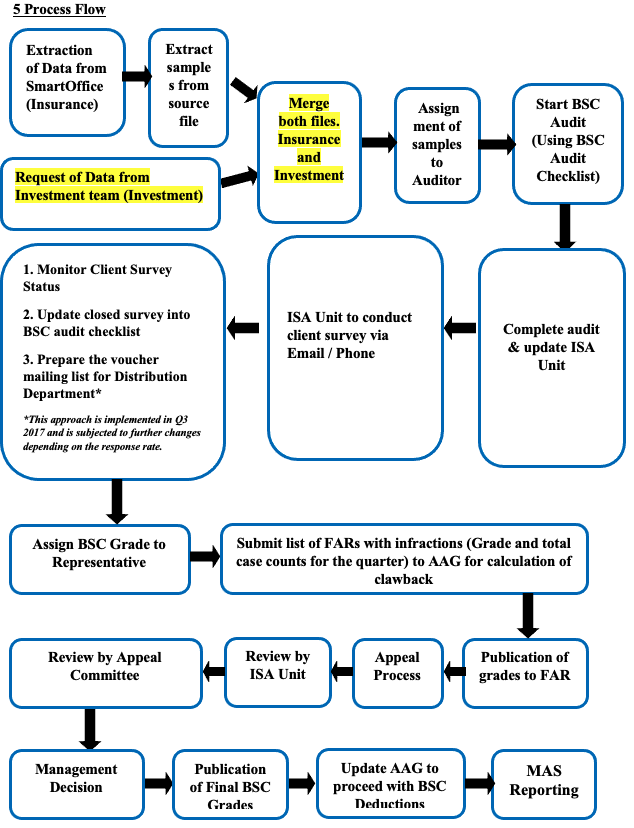

For easy reference purpose, there will be a copy of the code in my Github <br>
https://github.com/orlandokohjy/IPP-BSC/blob/main/IPP%20BSC%20v20211020%20(for%20IPP).ipynb

you can retrieve the codes as long as you can trace to my Github account

Additional information:<br>
i) interested in Anaconda package: https://www.mrdbourke.com/get-your-computer-ready-for-machine-learning-using-anaconda-miniconda-and-conda/

In [ ]:
!pip uninstall -y fuzzywuzzy

In [4]:
import pip

package_1 = 'fuzzywuzzy'
try:
    __import__(package_1)
except ImportError:
    pip.main(['install', package_1])


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl (18 kB)


In [ ]:
# Skip running this cell if this is NOT your first time running this script
pip install pandas
pip install fuzzywuzzy

In [5]:
!pip list

Package                            Version
---------------------------------- -------------------
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 2.0.3
anaconda-project                   0.9.1
anyio                              2.2.0
appdirs                            1.4.4
applaunchservices                  0.2.1
appnope                            0.1.2
appscript                          1.1.2
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.5
astropy                            4.2.1
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.6
Babel                              2.9.0
backcall                           0.2.0
backports.functools-lru-cache      1.6.4
backports.shutil-get-terminal-size 1.0.0

In [1]:
import fuzzywuzzy

ModuleNotFoundError: No module named 'fuzzywuzzy'

## For 2020 Q3/Q4

In [7]:
# Final code (to be used)

import os
import pandas as pd
import numpy as np
import math


user_directory = input("Please input the directory to the files -> /Users/jiayikoh/KJY/IPP/2020 Q3/\n")
while os.path.isdir(user_directory) != True:
    user_directory = input("Directory does not exist, please re-enter the directory to the files -> /Users/jiayikoh/KJY/IPP/2020 Q3/\n")
os.chdir(user_directory)

insurance_file = input("Please input the Insurance file name (including the format) -> Compliance BSC.xlsx\n")
while os.path.isfile(insurance_file) != True:
    insurance_file = input('File name does not exist, please re-enter the Insurance file name -> Compliance BSC.xlsx\n')
    
investment_file_1 = input("Please input the 1st Investment file name (including the format) -> IPP Transaction Report - July 2020-Revised.xlsx\n")
while os.path.isfile(investment_file_1) != True:
    insurance_file_1 = input('File name does not exist, please re-enter the Investment file name -> IPP Transaction Report - July 2020-Revised.xlsx\n')
    
investment_file_2 = input("Please input the 2nd Investment file name (including the format) -> IPP Transaction Report - July 2020-Revised.xlsx\n")
while os.path.isfile(investment_file_2) != True:
    insurance_file_2 = input('File name does not exist, please re-enter the Investment file name -> IPP Transaction Report - July 2020-Revised.xlsx\n')

investment_file_3 = input("Please input the 3rd Investment file name (including the format) -> IPP Transaction Report - July 2020-Revised.xlsx\n")
while os.path.isfile(investment_file_3) != True:
    insurance_file_3 = input('File name does not exist, please re-enter the Investment file name -> IPP Transaction Report - July 2020-Revised.xlsx\n')
    
product_file = input("Please input the Approved Product List file (including the format) -> Consolidated Product list and bundled product Dec 2020.xlsx\n")
while os.path.isfile(product_file) != True:
    product_file = input('File name does not exist, please re-enter the Investment file name -> Consolidated Product list and bundled product Dec 2020.xlsx\n')
    
saved_file = input("Please input the file name to be saved after processing (include .xlsx) -> 2020Q3.xlsx")

compliance = pd.read_excel(insurance_file,header=[1]) 
compliance = pd.DataFrame(compliance)
cis_1 = pd.read_excel(investment_file_1,header=[0]) 
cis_2 = pd.read_excel(investment_file_2,header=[0])
cis_3 = pd.read_excel(investment_file_3,header=[0])
cis = pd.concat([cis_1, cis_2, cis_3], ignore_index = True)
pro = pd.read_excel(product_file, sheet_name = 'IPPFA App', header = [7])

##to manage insurance data
#Remove any data that contain blank in 'Advisor'
compliance.dropna(subset=['Advisor'], inplace = True)

#Remove duplicates except for two fields
compliance = compliance.drop_duplicates(subset=compliance.columns.difference(['Modified On','Case Modified On']),keep='first')

#create 'BSC' column
compliance['Compliance BSC (Y/N)'] = ''

#open the 'IPPFA approved list' for 'Term Life' insurance plan
pro = pro.reindex(['Plan Type', 'Product Classification', 'Type', 'Carrier', 'Plan Name',
       'LPHR / Approved'], axis = 'columns', fill_value = '')
pro.dropna(axis = 0, inplace = True)

#merge both files for easy data manipulation (to check whether there is wrong labelling for 'Term Life')
compliance = pd.merge(compliance, pro, how = 'left', on = 'Plan Name')

#fill all missing values with blank
compliance.fillna('', inplace = True)

#to check against the IPPFA Approved list
compliance.rename(columns = {'Plan Type_x':'Plan Type'}, inplace = True)
check_1 = compliance['Type'].str.contains('Term Life')
compliance.loc[check_1, 'Plan Type'] = compliance['Type']
compliance.loc[compliance['Plan Type'] == '', 'Plan Type'] = compliance['Type']

#for term life, wrong labelling for 'Plan Type' in the compliance file
hi_1 = compliance['Plan Type'] == 'Term Life'
hi_2 = ~compliance['Type'].str.contains('Term Life')
hi_3 = compliance['Type'] != ''

compliance.loc[hi_1 & hi_2 & hi_3, 'Compliance BSC (Y/N)'] = 'No'


#inserting new columns
compliance.insert(loc=21, column='Rider Remarks', value='')
import re

compliance.loc[compliance['Plan Type'].str.contains('Commercial|Dread Diseases/Critical Illness|Eldershield|Hospital & Surgical|Medishield', flags=re.IGNORECASE, regex = True),'Compliance BSC (Y/N)'] = 'No (A&H)'

compliance.loc[compliance['Plan Type'].str.contains('LTC'),'Compliance BSC (Y/N)'] = 'No (CIS)'

compliance.loc[compliance['Accredited Investor'].str.contains('Yes'),'Compliance BSC (Y/N)'] = 'No (Al)'

compliance.loc[compliance['Subject To BSC'].str.contains('Corporate') | compliance['Contact Name'].str.contains('pte|ltd', flags=re.IGNORECASE, regex = True) | compliance['Plan Name'].str.contains('HSBC', flags=re.IGNORECASE, regex = True),'Compliance BSC (Y/N)'] = 'No (Others)'

compliance.loc[compliance['Subject To BSC'] == '', 'Compliance BSC (Y/N)'] = 'No'

compliance.loc[compliance['Subject To BSC'].str.contains('A&H'),'Compliance BSC (Y/N)'] = 'No (A&H)'

hi_4 = compliance['Subject To BSC'] == ''
hi_5 = compliance['Compliance BSC (Y/N)'] == ''

compliance.loc[hi_1 & hi_4,'Compliance BSC (Y/N)'] = 'Yes'
compliance.loc[hi_5,'Compliance BSC (Y/N)'] = compliance['Subject To BSC']

#to identify FAR own trade policy using name
farreq1 = compliance['Compliance BSC (Y/N)'] == 'No (No Advice)'
farreq2 = compliance['Compliance BSC (Y/N)'] == 'Yes'

#remove whitespace for all names columns in order to find whether is FAR own trade policy
compliance['name_check_1'] = compliance.loc[:,'Advisor'].str.lower().str.strip().str.replace(' ','')
compliance['name_check_2'] = compliance.loc[:,'Contact Name'].str.lower().str.strip().str.replace(' ','')
compliance['name_check_3'] = compliance.loc[:,'All Advisors'].str.lower().str.strip().str.replace(' ','')

def check_name(row):
    return row['name_check_1'] in row['name_check_2'] or row['name_check_2'] in row['name_check_1'] or row['name_check_2'] in row['name_check_3'] or row['name_check_3'] in row['name_check_2']

compliance.loc[(farreq1 | farreq2) & compliance.apply(check_name, axis = 1),('Compliance BSC (Y/N)')] = 'Yes (FAR own trade)'

#to identify FAR own trade policy using client's email address
compliance.loc[(farreq1 | farreq2) & compliance['All E-mail Addresses.1'].str.contains('ippfa.com'),'Compliance BSC (Y/N)'] = "Yes (FAR own trade)"

#create new columns with blank value in order to match the Ins file
#renaming columns to match Ins file
column_1 = ['Advisor',"All E-mail Addresses",'Created On',"Contact Name","Contact ID#","All E-mail Addresses.1","Complete Address","Unformatted Postal code","DOB","Age","Nationality","Job Title","Unusual_Symbol","Lump Sum","RSP","Frequency (RSP ONLY)","No Frequency (RSP ONLY)","Error Frequency","Annualized Premium with Rider","Carrier Name","Policy #","Plan Name","Plan Type","Effective Date","Status","Status Date","Subject To BSC", "Compliance BSC (Y/N)","IPP Advisory Group","All Advisors","Modified On","Case Modified On","Accrediated Investor"]

compliance = compliance.reindex(column_1, axis = 'columns')


#Filter all Compliance BSC Yes information
condition1 = compliance['Compliance BSC (Y/N)'].str.contains('Yes')
compliance = compliance[condition1]

##to manage investment data
#calculate age
now = pd.Timestamp('now')    
cis["Client's DOB"] = pd.to_datetime(cis["Client's DOB"], format = '%Y-%m-%d', )
cis["Client's DOB"] = cis["Client's DOB"].where(cis["Client's DOB"] < now, cis["Client's DOB"] -  np.timedelta64(100, 'Y'))
cis['Age'] = (now - cis["Client's DOB"]).astype('<m8[Y]')

#to flag out any unusual symbol in the Lump Sum column
def extract_symbol(val: str):
    if not isinstance(val, str):
        return ''
    regex = r"(\D+)\D*"
    match = re.findall(regex, val)
    return match

cis['Unusual_Symbol'] = cis['Lump Sum'].apply(extract_symbol)

#to extract digit only for lump sum amount
cis['Lump Sum'].replace(',','',inplace = True,regex = True)

import re

def extract_number(val: str):
    if not isinstance(val, str):
        return val
    regex = r"\D*(\d+)\D*"
    match = re.match(regex, val)
    return match.group(1)

cis['Lump Sum'] = cis['Lump Sum'].apply(extract_number)
cis['Lump Sum'] = pd.to_numeric(cis['Lump Sum'])


#replace RSP and Lump Sum NaN to 0
index_rsp = cis.loc[cis['RSP'].isna(),'RSP'].index
cis.loc[cis['RSP'].isna(),'RSP'] = 0
cis.loc[cis['Lump Sum'].isna(), 'Lump Sum'] = 0

#fill all missing values as blank
cis.fillna('', inplace = True)

#create a new column converting frequency to number
cis['No Frequency (RSP ONLY)'] = cis['Frequency (RSP ONLY)'].apply(lambda x: 2 if 'Semi' in x else (4 if 'Quarter' in x else (12 if 'Month' in x else (1 if 'Annual' in x else 0))))

#create a new column to detect any error in frequency
cis['Error Frequency'] = ''
cond_1 = cis['No Frequency (RSP ONLY)'] == 0
cond_2 = cis['Frequency (RSP ONLY)'] != ''
cis.loc[cond_1 & cond_2,'Error Frequency'] = 'Error'

#create RSP total using the new column value above
cis['RSP Total'] = cis['No Frequency (RSP ONLY)'] * cis['RSP']

#sum RSP and lump sum in a new column 'Annualized Premium with Rider'
cis['Annualized Premium with Rider'] = cis['Lump Sum'] + cis['RSP Total']
#cis['Annualized Premium with Rider'] = cis.loc[:,['Lump Sum','RSP Total']].sum(axis=1)

#create 'Final BSC (Y/N)' column
cis['Final BSC (Y/N)'] = cis['Remarks'].apply(lambda x: 'Yes (FAR own trade)' if 'FAR own' in x else ('No Al' if 'Al' in x else 'Yes'))

#overwrite 'Final BSC (Y/N)' value to 'Yes (FAR own trade)' for both same email address and both same name
cis.loc[(cis["Advisor's email address"] == cis["Client's Email Add"]),'Final BSC (Y/N)'] = 'Yes (FAR own trade)'
cis.loc[(cis["Advisor"] == cis["Client's Name"]),'Final BSC (Y/N)'] = 'Yes (FAR own trade)'

#new columns 'Effective Date' & 'Status Date' same as 'Submission Date'
cis['Effective Date'] = cis['Submission Date']
cis['Status Date'] = cis['Submission Date']

# create new columns with blank value in order to match the Ins file
#renaming columns to match Ins file
cis.rename(columns = {'Transaction Type':'Plan Type'}, inplace = True)
column_1 = ['Advisor',"Advisor's email address",'Submission Date',"Client's Name","Client's NRIC","Client's Email Add","Complete Address","Unformatted Postal code","Client's DOB","Age","Nationality","Job Title","Unusual_Symbol","Lump Sum","RSP","Frequency (RSP ONLY)","No Frequency (RSP ONLY)","Error Frequency","Annualized Premium with Rider","Carrier","Policy No.","Plan Name","Plan Type","Effective Date","Mode","Status Date","Subject To BSC","Final BSC (Y/N)","IPP Advisory Group","All Advisors","Modified On","Case Modified On","Accrediated Investor"]
#column_1 = ['Advisor']
cis = cis.reindex(column_1, axis = 'columns')

condition1 = cis['Final BSC (Y/N)'].str.contains('Yes')
cis = cis[condition1]

compliance.columns = cis.columns

# to group the same Advisor name
compliance_names = list(compliance['Advisor'].unique())
cis_names = list(cis['Advisor'].unique())

# to install 'fuzzywuzzy' package if is not installed
import pip

package_1 = 'fuzzywuzzy'
try:
    __import__(package_1)
except ImportError:
    pip.main(['install', package_1])

from fuzzywuzzy import fuzz

def match_names(name, list_names, min_score = 0):
    max_score = -1
    max_name = ''
    for x in list_names:
        score = fuzz.ratio(name, x)
        if (score > min_score) & (score > max_score):
            max_name = x
            max_score = score
    return (max_name, max_score)

names = []
for x in cis_names:
    match = match_names(x, compliance_names, 50)
    if match[1] >= 50:
        name = (str(x), str(match[0]))
        names.append(name)
name_dict = dict(names)

cis['Advisor'] = cis['Advisor'].replace(name_dict)


# to group the same Advisory Group
compliance_adgroup = list(compliance['IPP Advisory Group'].unique())
cis_adgroup = list(compliance['IPP Advisory Group'].unique())

adgroup_names = []
for x in cis_adgroup:
    match = match_names(x, compliance_adgroup, 50)
    if match[1] >= 50:
        name = (str(x), str(match[0]))
        adgroup_names.append(name)
adgroup_dict = dict(adgroup_names)

cis['IPP Advisory Group'] = cis['IPP Advisory Group'].replace(adgroup_dict)


#pd.concat([compliance,cis],ignore_index = False)
combined = pd.concat([compliance,cis],ignore_index = False, keys = ['Ins', 'Cis'], names = ['From where?'])
combined = combined.reset_index().drop(columns = 'level_1')

#reformat all the date columns to be consistent
combined["Submission Date"] = pd.to_datetime(combined["Submission Date"]).dt.normalize()
combined["Client's DOB"] = pd.to_datetime(combined["Client's DOB"]).dt.normalize()
combined["Effective Date"] = pd.to_datetime(combined["Effective Date"]).dt.normalize()
combined["Status Date"] = pd.to_datetime(combined["Status Date"]).dt.normalize()
combined["Modified On"] = pd.to_datetime(combined["Modified On"]).dt.normalize()
combined["Case Modified On"] = pd.to_datetime(combined["Case Modified On"]).dt.normalize()

combined.sort_values(by=['Advisor','Annualized Premium with Rider','Final BSC (Y/N)'], ascending = (True, False, True), inplace = True)    

#calculate the total number of policy for each advisor
combined['Total No Policy'] = combined.groupby('Advisor')['Advisor'].transform('count')


#find the median number for each advisor then match against their cumulative count to extract the dataframe
combined['Median'] = np.ceil(combined['Total No Policy']/2)
combined['Cumulative'] = combined.groupby('Advisor').cumcount() + 1
combined['number_away_from_median'] = abs(combined['Median'] - combined['Cumulative'])

#calculate the number of audit cases
combined['Round 1 Audit'] = combined['Total No Policy'].apply(lambda x: max(1,round(x*0.05)))
combined['Round 2 Audit'] = combined['Total No Policy'].apply(lambda x: max(1,round(x*0.1)) if x > 1 else 0)
combined['Round 3 Audit'] = combined['Total No Policy'].apply(lambda x: max(1,round(x*0.2)) if x > 2 else 0)

combined.sort_values(by=['Advisor','Final BSC (Y/N)','number_away_from_median'], ascending = (True, True, True), inplace = True)

# method 1: median
#find the median number for each advisor then match against their cumulative count to extract the dataframe
#round 1
median_row_all = []
result = []

for _, v in enumerate(combined['Advisor'].unique()):
    temp_df = combined[combined['Advisor'] == v]
    temp_df.reset_index(inplace = True)
    round_no = temp_df.at[0,'Round 1 Audit']

    for j in range(round_no):
        median_row = j
        median_row_all.append(temp_df.iloc[[median_row]])
median_row_all = pd.concat(median_row_all)

#round 2
median_row_all_r2 = []
result = []

for _, v in enumerate(combined['Advisor'].unique()):
    temp_df = combined[combined['Advisor'] == v]
    temp_df.reset_index(inplace = True)
    previous_round = temp_df.at[0,'Round 1 Audit']
    round_no = temp_df.at[0,'Round 2 Audit']
    
    for j in range(round_no):
        median_row = j + previous_round
        median_row_all_r2.append(temp_df.iloc[[median_row]])
median_row_all_r2 = pd.concat(median_row_all_r2)

#round 3
median_row_all_r3 = []
result = []

for _, v in enumerate(combined['Advisor'].unique()):
    temp_df = combined[combined['Advisor'] == v]
    temp_df.reset_index(inplace = True)
    previous_round = temp_df.at[0,'Round 1 Audit'] + temp_df.at[0,'Round 2 Audit']
    round_no = temp_df.at[0,'Round 3 Audit']
    
    for j in range(round_no):
        median_row = j + previous_round
        median_row_all_r3.append(temp_df.iloc[[median_row]])
median_row_all_r3 = pd.concat(median_row_all_r3)


# method 2: start highest annualized premium

# sort dataframe from highest to lowest
combined.sort_values(by=['Advisor','Final BSC (Y/N)','Annualized Premium with Rider'], ascending = (True, True, False), inplace = True)

# round 1
highest_r1 = []

for _, v in enumerate(combined['Advisor'].unique()):
    temp_df = combined[combined['Advisor'] == v]
    temp_df.reset_index(inplace = True)
    round_no = temp_df.at[0,'Round 1 Audit']
    
    for j in range(round_no):
        highest_row = j
        highest_r1.append(temp_df.iloc[[highest_row]])
highest_r1 = pd.concat(highest_r1)

# round 2
highest_r2 = []

for _,v in enumerate(combined['Advisor'].unique()):
    temp_df = combined[combined['Advisor'] == v]
    temp_df.reset_index(inplace = True)
    previous_round = temp_df.at[0,'Round 1 Audit']
    round_no = temp_df.at[0,'Round 2 Audit']
    
    for j in range(round_no):
        highest_row = previous_round + j
        highest_r2.append(temp_df.iloc[[highest_row]])
highest_r2 = pd.concat(highest_r2)

# round 3
highest_r3 = []

for _, v in enumerate(combined['Advisor'].unique()):
    temp_df = combined[combined['Advisor'] == v]
    temp_df.reset_index(inplace = True)
    previous_round = temp_df.at[0,'Round 1 Audit'] + temp_df.at[0,'Round 2 Audit']
    round_no = temp_df.at[0,'Round 3 Audit']
    
    for j in range(round_no):
        highest_row = previous_round + j
        highest_r3.append(temp_df.iloc[[highest_row]])
highest_r3 = pd.concat(highest_r3)


#create a new dataframe for audit number purpose
advisor_count = combined.loc[:, 'Advisor'].value_counts()

advisor_count = advisor_count.to_frame()

advisor_count.rename(columns = {'Advisor': 'Total Number of Policy'}, inplace = True)
advisor_count['Round 1 Audit'] = advisor_count['Total Number of Policy'].apply(lambda x: max(1,round(x*0.05)))
advisor_count['Round 2 Audit'] = advisor_count['Total Number of Policy'].apply(lambda x: max(1,round(x*0.1)) if x > 1 else 0)
advisor_count['Round 3 Audit'] = advisor_count['Total Number of Policy'].apply(lambda x: max(1,round(x*0.2)) if x > 2 else 0)

#Filter old advisor information
aacond = 'Old -'
check_1 = (combined['All Advisors'].str.contains(aacond)) & (compliance['Final BSC (Y/N)'] == 'Yes')
oldadvisor_df = combined[check_1]


# create a new dataframe for Advisory Group with number of counts
advisory_group = combined.loc[:, 'IPP Advisory Group'].value_counts()

advisory_group = advisory_group.to_frame()

advisory_group.rename(columns = {'IPP Advisory Group': 'Total Number of Cases'}, inplace = True)
advisory_group['Round 1 Total Number of Cases'] = median_row_all.loc[:, 'IPP Advisory Group'].value_counts()
advisory_group['Round 2 Total Number of Cases'] = median_row_all_r2.loc[:, 'IPP Advisory Group'].value_counts()
advisory_group['Round 3 Total Number of Cases'] = median_row_all_r3.loc[:, 'IPP Advisory Group'].value_counts()


# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(saved_file)

# # Write each dataframe to a different worksheet.
combined.to_excel(writer, sheet_name = 'Ins + Cis (Y)')
median_row_all.to_excel(writer, sheet_name = 'Median R1')
median_row_all_r2.to_excel(writer, sheet_name = 'Median R2')
median_row_all_r3.to_excel(writer, sheet_name = 'Median R3')
highest_r1.to_excel(writer, sheet_name = 'Highest Premium R1')
highest_r2.to_excel(writer, sheet_name = 'Highest Premium R2')
highest_r3.to_excel(writer, sheet_name = 'Highest Premium R3')
oldadvisor_df.to_excel(writer, sheet_name = 'Check Old Advisor')
advisor_count.to_excel(writer, sheet_name = 'Advisor Counts')
advisory_group.to_excel(writer, sheet_name = 'Advisory Group Counts')


# # Close the Pandas Excel writer and output the Excel file.
writer.save()

Please input the directory to the files -> /Users/jiayikoh/KJY/IPP/2020 Q3/
/Users/jiayikoh/KJY/IPP/2020 Q3/
Please input the Insurance file name (including the format) -> Compliance BSC.xlsx
Compliance BSC.xlsx
Please input the 1st Investment file name (including the format) -> IPP Transaction Report - July 2020-Revised.xlsx
IPP Transaction Report - July 2020-Revised.xlsx
Please input the 2nd Investment file name (including the format) -> IPP Transaction Report - July 2020-Revised.xlsx
IPP Transaction Report - August 2020-revised.xlsx
Please input the 3rd Investment file name (including the format) -> IPP Transaction Report - July 2020-Revised.xlsx
IPP Transaction Report - September 2020 - revised.xlsx
Please input the Approved Product List file (including the format) -> Consolidated Product list and bundled product Dec 2020.xlsx
Consolidated Product list and bundled product Dec 2020.xlsx
Please input the file name to be saved after processing (include .xlsx) -> 2020Q3.xlsxtest_9Jan.x

/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
<ipython-input-7-230603d96f15>:397: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  oldadvisor_df = combined[check_1]
